In [15]:
import IPython
IPython.display.HTML('<div class="flourish-embed flourish-bar-chart-race" data-src="visualisation/1977187" data-url="https://flo.uri.sh/visualisation/1977187/embed"><script src="https://public.flourish.studio/resources/embed.js"></script></div>')

In [16]:
import pandas as pd
import numpy as np
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from time import time
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
df=pd.read_csv('https://raw.githubusercontent.com/chesterking123/PredictingCovid19India-Arima/master/covid_19_india.csv')

In [18]:
df.tail()

,Sno,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
1185,1186,21/04/20,5:00 PM,Telengana,-,-,190,23,919
1186,1187,21/04/20,5:00 PM,Tripura,-,-,1,0,2
1187,1188,21/04/20,5:00 PM,Uttarakhand,-,-,18,0,46
1188,1189,21/04/20,5:00 PM,Uttar Pradesh,-,-,140,20,1294
1189,1190,21/04/20,5:00 PM,West Bengal,-,-,73,12,392


# PREPROCESSING AND CLEANING

In [19]:
data = df.copy()
data['Date']=data['Date'].apply(pd.to_datetime)
data.drop(['Sno','Time'],axis=1,inplace=True)

from datetime import date
data_apr = data[data['Date'] >= pd.Timestamp(date(2020,4,19))]

state_cases = data_apr.groupby('State/UnionTerritory')['Confirmed','Deaths','Cured'].max().reset_index()
state_cases['Active'] = state_cases['Confirmed'] - (state_cases['Deaths']+state_cases['Cured'])
state_cases['Death_Rate(per_100)'] = np.round(100*state_cases['Deaths']/state_cases['Confirmed'],2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [20]:
state_cases

,State/UnionTerritory,Confirmed,Deaths,Cured,Active,Death_Rate(per_100)
0,Andaman and Nicobar Islands,16,0,11,5,0.00
1,Andhra Pradesh,757,22,96,639,2.91
2,Arunachal Pradesh,1,0,1,0,0.00
3,Assam,35,1,19,15,2.86
4,Bihar,114,2,42,70,1.75
5,Chandigarh,26,0,13,13,0.00
6,Chhattisgarh,36,0,25,11,0.00
7,Delhi,2081,47,431,1603,2.26
8,Goa,7,0,7,0,0.00
9,Gujarat,2066,77,131,1858,3.73


# STATEWISE

In [21]:
print("** STATE WISE CONFIRMED, DEATH AND CURED CASES of 2019-nCoV**")
state_cases.sort_values('Confirmed', ascending=False).style.background_gradient(cmap='Blues',subset=['Confirmed'])\
.background_gradient(cmap='Reds',subset=['Deaths'])\
.background_gradient(cmap='Greens',subset=['Cured'])\
.background_gradient(cmap='pink',subset=['Active'])\
.background_gradient(cmap='Purples',subset=["Death_Rate(per_100)"])

** STATE WISE CONFIRMED, DEATH AND CURED CASES of 2019-nCoV**


,State/UnionTerritory,Confirmed,Deaths,Cured,Active,Death_Rate(per_100)
18,Maharashtra,4669,232,572,3865,4.970000
7,Delhi,2081,47,431,1603,2.260000
9,Gujarat,2066,77,131,1858,3.730000
27,Rajasthan,1576,25,205,1346,1.590000
17,Madhya Pradesh,1540,76,127,1337,4.940000
28,Tamil Nadu,1520,17,457,1046,1.120000
31,Uttar Pradesh,1294,20,140,1134,1.550000
29,Telengana,919,23,190,706,2.500000
1,Andhra Pradesh,757,22,96,639,2.910000
14,Karnataka,415,17,114,284,4.100000


In [22]:
spread = pd.read_csv('https://raw.githubusercontent.com/chesterking123/PredictingCovid19India-Arima/master/covid_19_india.csv')
spread['Date'] = pd.to_datetime(spread['Date'], dayfirst=True,)
india_spread = spread
india_spread['Active'] = india_spread['Confirmed'] - (india_spread['Deaths'] + india_spread['Cured'])
india_spread = india_spread.groupby('Date')['Confirmed','Deaths','Cured', 'Active'].sum().reset_index()
india_spread['Confirmed_diff'] = india_spread['Confirmed'].diff()
india_spread['Death_diff'] = india_spread['Deaths'].diff()
india_spread['Recovered_diff'] = india_spread['Cured'].diff()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


In [23]:
datewise = india_spread.groupby('Date')['Confirmed','Deaths','Cured', 'Active'].sum().reset_index()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [24]:
datewise.head(20)

,Date,Confirmed,Deaths,Cured,Active
0,2020-01-30,1,0,0,1
1,2020-01-31,1,0,0,1
2,2020-02-01,2,0,0,2
3,2020-02-02,3,0,0,3
4,2020-02-03,3,0,0,3
5,2020-02-04,3,0,0,3
6,2020-02-05,3,0,0,3
7,2020-02-06,3,0,0,3
8,2020-02-07,3,0,0,3
9,2020-02-08,3,0,0,3


# Arima Model

ARIMA stands for AutoRegressive (AR) Integrated (I) Moving Average (MA). The provided data as input must be an univariate series, since ARIMA calculates future datapoints from the past. That is exactly what we were trying to do with linear regression as well. ARIMA basically has three important parameters:

p: The autoregressive part of the model. Simplified one can say that the model assumes that if there were many confirmed cases yesterday and the day before, there will be many confirmed cases today and tomorrow.

d -> The integrated part of the model that describes the amount of differentiation. If the available data are not stationary and contain trends, ARIMA can extract this seasonality.

q -> The moving average part of the model. By forming moving averages, random effects can be smoothed.

No handles with labels found to put in legend.


(array([-20.,   0.,  20.,  40.,  60.,  80., 100.]),
 <a list of 7 Text major ticklabel objects>)

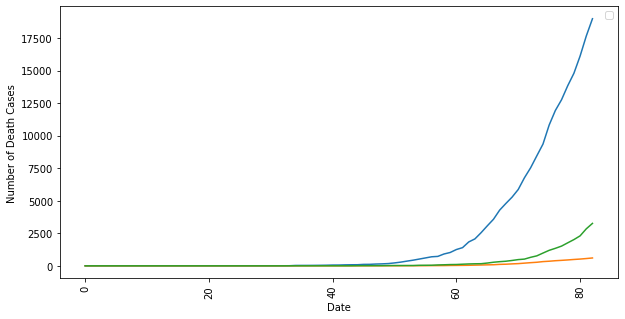

In [25]:
pyplot.figure(figsize=(10,5))
pyplot.plot(datewise["Confirmed"])
pyplot.plot(datewise["Deaths"])
pyplot.plot(datewise["Cured"])

pyplot.legend()
pyplot.xlabel("Date")
pyplot.ylabel("Number of Death Cases")
pyplot.xticks(rotation=90)

In [26]:
confirmedcases = datewise['Confirmed'].to_list()
confirmedcases

[1,
 1,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 5,
 6,
 28,
 30,
 31,
 34,
 39,
 46,
 58,
 60,
 74,
 81,
 84,
 110,
 114,
 137,
 151,
 173,
 223,
 283,
 360,
 433,
 519,
 606,
 694,
 724,
 909,
 1024,
 1251,
 1397,
 1834,
 2069,
 2547,
 3072,
 3577,
 4281,
 4789,
 5274,
 5865,
 6761,
 7529,
 8447,
 9352,
 10815,
 11933,
 12759,
 13835,
 14792,
 16116,
 17656,
 18985]

In [27]:
plotconf = datewise['Confirmed']

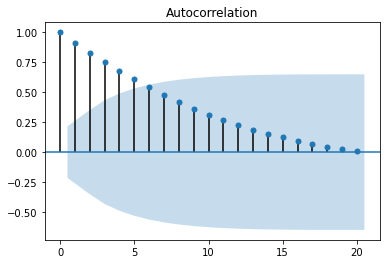

In [28]:
plot_acf(plotconf)
pyplot.show()

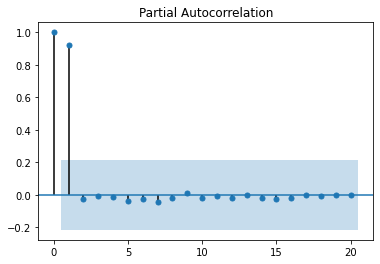

In [29]:
plot_pacf(plotconf)
pyplot.show()

In [30]:
model_arima=ARIMA(confirmedcases,(1,1,0))
model_arima_fit=model_arima.fit()
prediction_arima=model_arima_fit.forecast(7)[0]
prediction_arima

array([20289.32303022, 21569.64809119, 22826.63550037, 24060.92740621,
       25273.14828809, 26463.9054425 , 27633.78945583])

In [31]:
plotingconfirmed = datewise.copy()
del plotingconfirmed['Deaths']
del plotingconfirmed['Cured']
del plotingconfirmed['Active']

In [32]:
oneweekdates = ['2020-4-22','2020-4-23','2020-4-24','2020-4-25','2020-4-26','2020-4-27','2020-4-28']

In [33]:
plotingconfirmed.tail()

,Date,Confirmed
78,2020-04-17,13835
79,2020-04-18,14792
80,2020-04-19,16116
81,2020-04-20,17656
82,2020-04-21,18985


In [34]:
j=1
for i in range(len(oneweekdates)):
    plotingconfirmed.loc[82+j,'Date'] = oneweekdates[i]
    plotingconfirmed.loc[82+j,'Confirmed'] =int(prediction_arima[i])
    j=j+1

In [35]:
plotingconfirmed['Date'] = pd.to_datetime(plotingconfirmed['Date'])

In [36]:
plotingconfirmed.tail(20)

,Date,Confirmed
70,2020-04-09,5865.0
71,2020-04-10,6761.0
72,2020-04-11,7529.0
73,2020-04-12,8447.0
74,2020-04-13,9352.0
75,2020-04-14,10815.0
76,2020-04-15,11933.0
77,2020-04-16,12759.0
78,2020-04-17,13835.0
79,2020-04-18,14792.0


In [37]:
arimapredictions = plotingconfirmed.copy()

In [38]:
arimapredictions.to_csv('Arima_predictions.csv')

(array([-20.,   0.,  20.,  40.,  60.,  80., 100.]),
 <a list of 7 Text major ticklabel objects>)

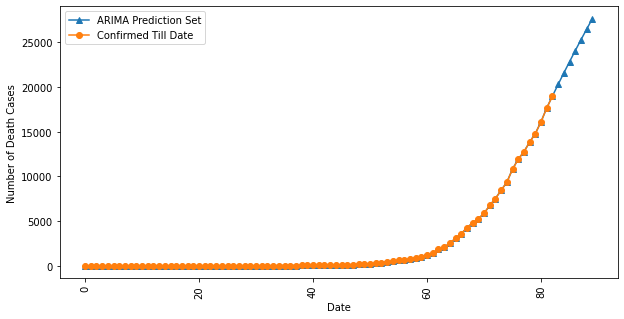

In [39]:
pyplot.figure(figsize=(10,5))
pyplot.plot(plotingconfirmed["Confirmed"],label="ARIMA Prediction Set",marker="^")
pyplot.plot(datewise["Confirmed"],label="Confirmed Till Date",marker="o")
pyplot.legend()
pyplot.xlabel("Date")
pyplot.ylabel("Number of Death Cases")
pyplot.xticks(rotation=90)